# Study A
This notebook shows the full workflow for building models, simulating growth and obtaining SCFA predictions from data collected by the _ex vivo_ study conducted by the Gibbons Lab in 2019

In [2]:
import pandas as pd
import micom
import micom.measures
from plotnine import * 
from tqdm import tqdm
import scipy

%matplotlib inline

## Flux Calculation
Here we will calculate production rate from the experimental SCFA measurements and convert them to dicts for later use

In [3]:
scfa=pd.read_excel('/proj/gibbons/ex_vivos_2019/data/ISBI-0202-19TASA_Results.xlsx')
scfa=scfa[['Unique Sample ID','Treatment','Time \nPoint','Subject or Animal ID','Analyte','Result']]
scfa=scfa.rename(columns={'Unique Sample ID':'sample_id',
                          'Time \nPoint':'timepoint',
                          'Treatment':'treatment',
                          'Subject or Animal ID':'subject_id',
                          'Analyte':'analyte','Result':'result'}).set_index('sample_id')
scfa['id'] = scfa['subject_id'].str[-1]+'_'+scfa['treatment']+'_'+scfa.index.str[1]
scfa['flux'] = scfa.groupby(['id','analyte'])['result'].diff()
metadata = scfa['id'].to_dict()
scfa = scfa.dropna()
scfa = pd.pivot_table(scfa,
                      index = 'id',
                      columns = 'analyte',
                      values = 'flux')
scfa = scfa/6
acetateMeasured = (scfa['Acetic acid']/59.04).to_dict()
butyrateMeasured = (scfa['Butyric acid']/88.11).to_dict()
propionateMeasured = (scfa['Propionic acid']/74.08).to_dict()
scfa

analyte,2-Methylbutyric acid,Acetic acid,Butyric acid,Hexanoic acid,Isobutyric acid,Isovaleric acid,Propionic acid,Valeric acid
id,,,,,,,,
A_PBS_1,2.916667,99.666667,15.966667,6.216667,2.883333,3.483333,11.383333,5.033333
A_PBS_2,2.733333,75.166667,15.966667,6.850000,3.283333,2.566667,9.633333,5.316667
A_PBS_3,3.000000,79.166667,16.500000,5.766667,2.816667,3.400000,13.183333,4.733333
A_inulin_1,0.433333,365.833333,268.666667,30.050000,1.500000,-0.100000,98.016667,11.533333
A_inulin_2,-0.083333,365.833333,250.333333,31.716667,1.650000,0.233333,94.000000,11.633333
A_inulin_3,0.016667,364.500000,264.000000,31.483333,1.783333,0.300000,96.166667,12.316667
A_tryptophan_1,2.783333,78.000000,18.516667,4.883333,2.483333,3.383333,12.450000,4.466667
A_tryptophan_2,2.533333,76.333333,18.066667,5.166667,2.350000,2.483333,11.000000,4.500000
A_tryptophan_3,2.900000,73.500000,20.116667,4.816667,2.533333,3.266667,11.950000,5.483333


## Taxonomy Table
Next, we will read in abundance data for all samples. We will convert this into a taxnomy table to use in MICOM

In [4]:
taxonomy = pd.read_csv('/proj/gibbons/ex_vivos_2019/data/S_counts.csv')
taxonomy['sample_id'] = taxonomy['sample'].map(metadata)
taxonomy = taxonomy.rename(columns = 
                           {'d':'domain',
                            'p':'phylum', 
                            'c':'class',
                            'o':'order',
                            'f':'family',
                            'g':'genus',
                            's':'species',
                            'reads':'abundance'}).drop(
    columns = 'sample')
taxonomy['species'] = taxonomy['species'].str.split(' ').str[-1]
taxonomy['id'] = taxonomy['species'] 
taxonomy = taxonomy.groupby(['sample_id','species','id']).sum().reset_index()
taxonomy

/tmp/ipykernel_3271556/1423114991.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,sample_id,species,id,abundance
0,A_PBS_1,'caverna','caverna',67
1,A_PBS_1,002,002,24
2,A_PBS_1,01-6242,01-6242,53
3,A_PBS_1,014,014,14
4,A_PBS_1,01438,01438,44
...,...,...,...,...
56762,B_tryptophan_3,zoogleoformans,zoogleoformans,519
56763,B_tryptophan_3,zopfii,zopfii,81
56764,B_tryptophan_3,zucineum,zucineum,42
56765,B_tryptophan_3,zundukense,zundukense,42


## Build Models
Now, we'll build our models, with cutoff of 0.001

In [23]:
manifest = micom.workflows.build(taxonomy,
                               out_folder = '/proj/gibbons/nbohmann/exvivo/gibbons_2019/micom/models_sp',
                               model_db = '/proj/gibbons/nbohmann/exvivo/databases/agora103_species.qza',
                               cutoff = 0.001, 
                               threads = 20)

Output()

## Load Medium
Load in the carbon-stripped European Diet, and construct the intervention diets by augmenting with inulin and pectin

In [11]:
medium = pd.read_csv('/proj/gibbons/nbohmann/exvivo/diets/western_diet_depleted.csv')
medium['index'] = medium['reaction']
medium.set_index('index',inplace = True)
medium.at['EX_h2o_m','flux']=100000
medium['flux'] = medium['flux']/10

medium = pd.concat([medium, 
                    pd.DataFrame({'metabolite':['strch1_m', 'strch2_m','starch1200_m', 
                                                'dextrin_m','cellul_m'],
                                  'flux':[13, 13, .13,
                                          13, 0.00067],
                                  'reaction':['EX_strch1_m', 'EX_strch2_m', 'EX_starch1200_m', 
                                              'EX_dextrin_m', 'EX_cellul_m']},
                                 index = ['EX_strch1_m','EX_strch2_m', 'EX_starch1200_m',
                                         'EX_dextrin_m', 'EX_cellul_m'])])

controlMedium = medium

inulinMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_inulin_m'],
                                         'metabolite':['inulin_m'],
                                         'global_id':['EX_inulin(e)'],
                                         'flux':[14]
                                        },index = ['EX_inulin_m'])])
medium.to_csv('/users/nbohmann/exvivo/studyAmedium.csv')

# Grow Models
Now we'll grow the samples using the respective media we constructed

In [7]:
manifest = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gibbons_2019/micom/models/manifest.csv')
controlManifest = manifest[manifest['sample_id'].str.contains('PBS')]
inulinManifest = manifest[manifest['sample_id'].str.contains('inulin')]

controlGrowth = micom.workflows.grow(controlManifest,
                              '/proj/gibbons/nbohmann/exvivo/gibbons_2019/micom/models/',
                              controlMedium, 
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 20)
inulinGrowth = micom.workflows.grow(inulinManifest,
                              '/proj/gibbons/nbohmann/exvivo/gibbons_2019/micom/models/',
                              inulinMedium, 
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 20)

Output()

Output()

## Compare SCFA Fluxes
We can now extract the production fluxes of SCFAs from each growth simulation, and construct a dataframe with both measured and predicted production rates.

In [8]:
inulinProduction = micom.measures.production_rates(inulinGrowth)
controlProduction = micom.measures.production_rates(controlGrowth)
production = pd.concat([inulinProduction, controlProduction])
res = production[(production['name']==('butyrate'))|
                 (production['name']==('acetate'))|
                 (production['name']==('propionate'))]
res = pd.pivot(res, index = 'sample_id',
                    columns = 'name',
                    values = 'flux')
res.rename(columns = {'acetate':'acetatePredicted',
                      'butyrate':'butyratePredicted',
                      'propionate':'propionatePredicted'
                      }, inplace = True
          )
res['acetateMeasured'] = res.index.map(acetateMeasured)
res['butyrateMeasured'] = res.index.map(butyrateMeasured)
res['propionateMeasured'] = res.index.map(propionateMeasured)
shannon = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gibbons_2019/micom/shannon/alpha-diversity.tsv',
                      sep = '\t', index_col = 0)
shannon['sample_id'] = shannon.index.map(metadata)
shannon = shannon.set_index('sample_id')['shannon_entropy'].to_dict()
res['shannon'] = res.index.map(shannon)
res['donor'] = res.index.str.split('_').str[0]
res['treatment'] = res.index.str.split('_').str[1]

res.dropna(inplace = True)
sem = res.groupby(['treatment','donor']).sem().reset_index()
sem['sample_id'] = sem['treatment']+'_'+sem['donor']
sem.set_index('sample_id', inplace = True)
sem = sem.rename(columns = {'acetatePredicted':'acetatePredictedSEM',
                      'butyratePredicted':'butyratePredictedSEM',
                      'propionatePredicted':'propionatePredictedSEM',
                      'acetateMeasured':'acetateMeasuredSEM',
                      'butyrateMeasured':'butyrateMeasuredSEM',             
                      'propionateMeasured':'propionateMeasuredSEM',
                      'shannon':'shannonSEM'})
res = res.groupby(['treatment','donor']).mean().reset_index()
res['sample_id'] = res['treatment']+'_'+res['donor']
res.set_index('sample_id', inplace = True)
res = pd.concat([res, sem], axis = 1).T.drop_duplicates().T
res['treatment'] = res['treatment'].str.replace(
    'PBS','Control').str.replace(
    'inulin','Inulin')
res[res.columns[2:]] = res[res.columns[2:]].astype('float')

## Plot Results
Finally, we'll plot predicted vs measured fluxes against each other

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars


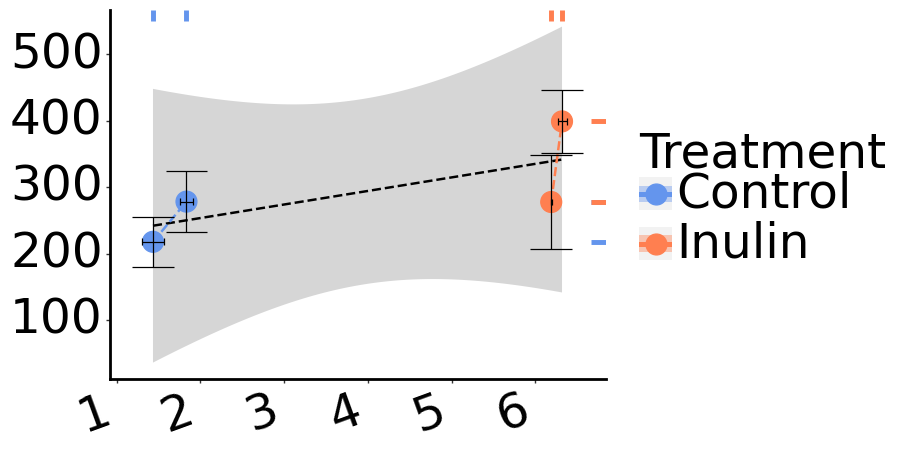

<ggplot: (8763246121135)>

In [60]:
fig1 = (ggplot(
    res, aes(x = 'acetateMeasured', y = 'acetatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'acetateMeasured', 
                       ymin = 'acetatePredicted - acetatePredictedSEM',
                       ymax = 'acetatePredicted + acetatePredictedSEM'))
    +geom_errorbarh(aes(y = 'acetatePredicted', 
                       xmin = 'acetateMeasured - acetateMeasuredSEM',
                       xmax = 'acetateMeasured + acetateMeasuredSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin'], values = ['cornflowerblue', 'coral'])
    +scale_fill_manual(limits = ['Control','Inulin'], values = ['cornflowerblue', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig1

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars


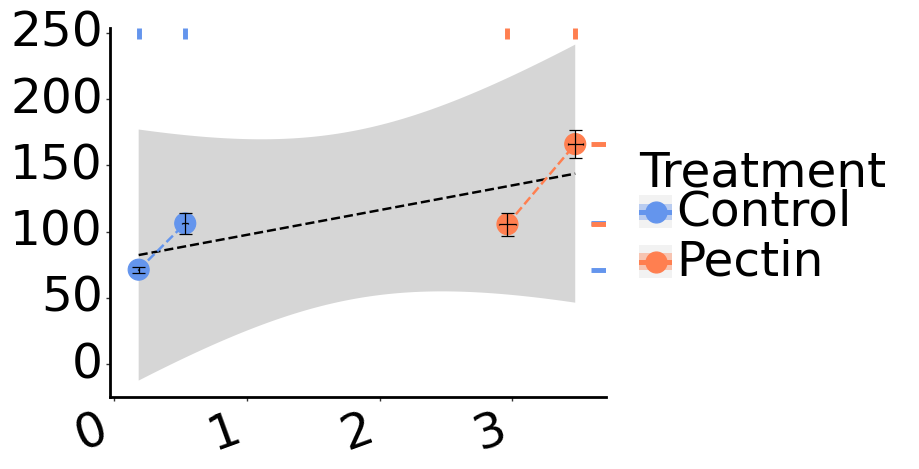

<ggplot: (8763376429376)>

In [61]:
fig2 = (ggplot(
    res, aes(x = 'butyrateMeasured', y = 'butyratePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'butyrateMeasured', 
                       ymin = 'butyratePredicted - butyratePredictedSEM',
                       ymax = 'butyratePredicted + butyratePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'butyratePredicted', 
                       xmin = 'butyrateMeasured - butyrateMeasuredSEM',
                       xmax = 'butyrateMeasured + butyrateMeasuredSEM'), height = 1)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin'], values = ['cornflowerblue', 'coral'])
    +scale_fill_manual(limits = ['Control','Pectin'], values = ['cornflowerblue', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig2

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars


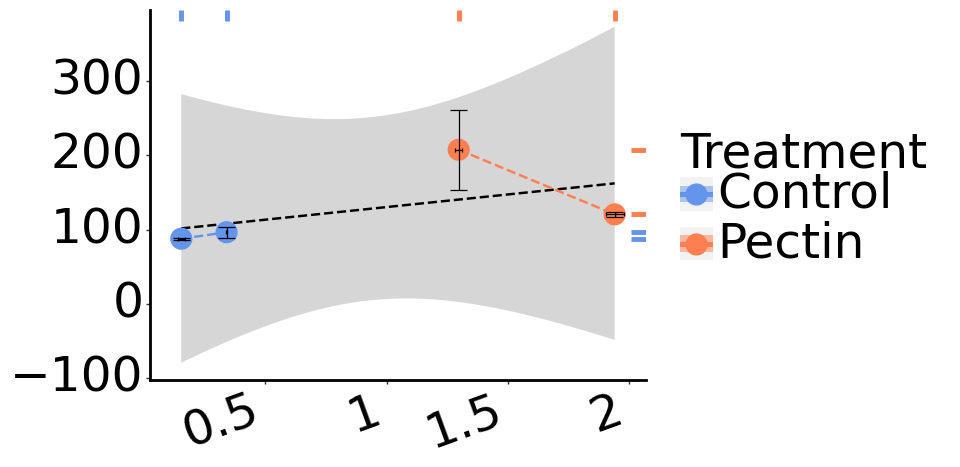

<ggplot: (8763379496093)>

In [62]:
fig3 = (ggplot(
    res, aes(x = 'propionateMeasured', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--', alpha = .5)
    +geom_errorbar(aes(x = 'propionateMeasured', 
                       ymin = 'propionatePredicted - propionatePredictedSEM',
                       ymax = 'propionatePredicted + propionatePredictedSEM'), width = .07)
    +geom_errorbarh(aes(y = 'propionatePredicted', 
                       xmin = 'propionateMeasured - propionateMeasuredSEM',
                       xmax = 'propionateMeasured + propionateMeasuredSEM'), height = 5)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Pectin'], values = ['cornflowerblue', 'coral'])
    +scale_fill_manual(limits = ['Control','Pectin'], values = ['cornflowerblue', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig3

## Calculate Linear Regressions

In [63]:
scipy.stats.linregress(res['propionatePredicted'], res['propionateMeasured'])

LinregressResult(slope=0.007944747640067322, intercept=-0.0852779810656158, rvalue=0.51980679141338, pvalue=0.48019320858662007, stderr=0.009232628409853047, intercept_stderr=1.2613814499212044)

## Save Results

In [44]:
ggsave(fig1,'/users/nbohmann/studyAac.png', dpi = 300)
ggsave(fig2,'/users/nbohmann/studyAbut.png', dpi = 300)
ggsave(fig3,'/users/nbohmann/studyAppa.png', dpi = 300)

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/studyAac.png
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /users/nbohmann/studyAbut.png
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/s

In [ ]:
fig4 = (ggplot(
    res, aes(x = 'shannon', y = 'acetatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'shannon', 
                       ymin = 'acetatePredicted - acetatePredictedSEM',
                       ymax = 'acetatePredicted + acetatePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'acetatePredicted', 
                       xmin = 'shannon - shannonSEM',
                       xmax = 'shannon + shannonSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin'], 
                        values = ['cornflowerblue', 'coral'])
    +scale_fill_manual(limits = ['Control','Inulin'], 
                       values = ['cornflowerblue', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig4

In [ ]:
fig5 = (ggplot(
    res, aes(x = 'shannon', y = 'butyratePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'shannon', 
                       ymin = 'butyratePredicted - butyratePredictedSEM',
                       ymax = 'butyratePredicted + butyratePredictedSEM'), width = 0.1)
    +geom_errorbarh(aes(y = 'butyratePredicted', 
                       xmin = 'shannon - shannonSEM',
                       xmax = 'shannon + shannonSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin'], 
                        values = ['cornflowerblue', 'coral'])
    +scale_fill_manual(limits = ['Control','Inulin'], 
                       values = ['cornflowerblue', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig5

In [ ]:
fig6 = (ggplot(
    res, aes(x = 'shannon', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_line(aes(groups = 'donor'))
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_errorbar(aes(x = 'shannon', 
                       ymin = 'propionatePredicted - propionatePredictedSEM',
                       ymax = 'propionatePredicted + propionatePredictedSEM'), width = 0.1)
    +geom_errorbarh(aes(y = 'propionatePredicted', 
                       xmin = 'shannon - shannonSEM',
                       xmax = 'shannon + shannonSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin'], 
                        values = ['cornflowerblue', 'coral'])
    +scale_fill_manual(limits = ['Control','Inulin'], 
                       values = ['cornflowerblue', 'coral'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig6

In [ ]:
ggsave(fig4,'/users/nbohmann/studyAacDiv.png', dpi = 300)
ggsave(fig5,'/users/nbohmann/studyAbutDiv.png', dpi = 300)
ggsave(fig6,'/users/nbohmann/studyAppaDiv.png', dpi = 300)

In [9]:
res.to_csv('/proj/gibbons/nbohmann/exvivo/gibbons_2019/studyA_genus.csv')